# Softmax A*

A simple implementation of A* with "softmax".

I've broken this notebook into a few steps for you to execute.

Requires Numpy.

## Algorithm

It's nearly A*, but with on difference.

Normally, in A*, at the start of a pass, we sort the "open set" according to the F-scores, and take the minimum score.

Here, we "flip" them (`V(i) = max(scores) / V(i)`), take the soft-max, divide by temperature, then sample.

## Demo

We run this for some number of executions, then form a heat map of edge traversals and render this with `networkx` and `matplotlib`.

## Questions?

You can write me at `jcooper@joecooper.me`.

In [ ]:
# For use by the algo

from typing import NamedTuple, FrozenSet
import math
from itertools import combinations
import numpy as np

# Demonstration render

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.offsetbox import AnchoredText

In [8]:
# This section initializes the graph generator. Run it, and scroll down.

class Node(NamedTuple):
    idx: int
    x: int
    y: int

class Edge(NamedTuple):
    nodes: FrozenSet[int]

class _DSU:
    def __init__(self, n: int) -> None:
        self.parent = list(range(n))

    def find(self, x: int) -> int:
        while self.parent[x] != x:
            self.parent[x] = self.parent[self.parent[x]]
            x = self.parent[x]
        return x

    def union(self, a: int, b: int) -> None:
        ra, rb = self.find(a), self.find(b)
        if ra != rb:
            self.parent[rb] = ra

    def one_component_left(self) -> bool:
        roots = {self.find(i) for i in range(len(self.parent))}
        return len(roots) == 1


def _segments_cross(p1, p2, p3, p4) -> bool:
    def orient(a, b, c):
        return (b[0] - a[0]) * (c[1] - a[1]) - (b[1] - a[1]) * (c[0] - a[0])

    if p1 == p3 or p1 == p4 or p2 == p3 or p2 == p4:
        return False  # sharing a node is allowed

    o1 = orient(p1, p2, p3)
    o2 = orient(p1, p2, p4)
    o3 = orient(p3, p4, p1)
    o4 = orient(p3, p4, p2)

    return (o1 * o2 < 0) and (o3 * o4 < 0)

def generate(
    node_count: int,
    field_size: int = 64) -> tuple[list[Node], list[Edge]]:
    identifiers = np.arange(node_count)
    x_coords = np.random.permutation(field_size)[:node_count]
    y_coords = np.random.permutation(field_size)[:node_count]
    _nodes = np.stack([identifiers, x_coords, y_coords], axis=1)
    nodes = list(set(Node(c[0].item(), c[1].item(), c[2].item()) for c in _nodes))
    edges = {}
    coords: Dict[int, Tuple[int, int]] = {n.idx: (n.x, n.y) for n in nodes}
    pairs = []
    for i in range(node_count):
        for j in range(i + 1, node_count):
            xi, yi = coords[i]
            xj, yj = coords[j]
            dist = math.hypot(xi - xj, yi - yj)
            pairs.append((dist, i, j))

    pairs.sort()  # closest first
    
    deg = [0] * node_count
    dsu = _DSU(node_count)
    chosen: List[Tuple[int, int]] = []
    for _, u, v in pairs:
        p1, p2 = coords[u], coords[v]
        if any(
            _segments_cross(p1, p2, coords[a], coords[b]) for a, b in chosen
        ):
            continue
        chosen.append((u, v))
        deg[u] += 1
        deg[v] += 1
        dsu.union(u, v)
    
    edges: list[Edge] = [
        Edge(frozenset((u, v))) for u, v in chosen
    ]
    return nodes, edges

def widest_separation(
    nodes: list[Node], edges: list[Edge]
) -> tuple[int, int]:
    max_d2 = -1.0
    best = (-1, -1)

    for n1, n2 in combinations(nodes, 2):
        dx = n1.x - n2.x
        dy = n1.y - n2.y
        d2 = dx * dx + dy * dy
        if d2 > max_d2:
            max_d2 = d2
            best = (n1.idx, n2.idx)
    return best

In [9]:
n_nodes = 32

nodes, edges = generate(n_nodes)

In [10]:
n_samples = 128
temperature = 1.0

def b_star(
    nodes: list[Node],
    edges: list[Edge],
    start: int,
    goal: int,
    temperature: float) -> list[int]:

    def d(idxa: int, idxb: int) -> int:
        alfa = node_by_key[idxa]
        bravo = node_by_key[idxb]
        x = alfa.x - bravo.x
        y = alfa.y - bravo.y
        return x * x + y * y
    
    def h(idx: int) -> int:
        return d(idx, goal)
    
    def reconstruct_path(came_from, current_idx):
        total_path = [current_idx]
        while current_idx in came_from:
            current_idx = came_from[current_idx]
            total_path = [current_idx] + total_path
        return total_path
    
    node_keys = [x.idx for x in nodes]
    node_by_key = dict((n.idx, n) for n in nodes)
    open_set = {start}
    pinf = d(start, goal) * 2 # pseudo-infinity
    
    came_from: dict[int, int] = dict()
    g_score: dict[int, int] = dict()
    f_score: dict[int, int] = dict()
    
    g_score[start] = 0
    f_score[start] = h(start)
    while len(open_set) > 0:
        s = sorted(open_set, key=lambda x: f_score[x])
        if len(s) == 1 or temperature == 0.0:
            current_idx = s[0]
        else:
            scores = np.array([f_score[x] for x in s], dtype=np.float32)
            logits = (scores.min().astype(float)) / scores
            logits = logits / temperature
            exp_vals = np.exp(logits - logits.max())
            probs = exp_vals / exp_vals.sum()
            sample = np.random.choice(len(probs), size=1, replace=False, p=probs)[0]
            current_idx = s[sample]
    
        if current_idx == goal:
            return reconstruct_path(came_from, current_idx)
    
        open_set.remove(current_idx)
        neighbors = set().union(*[e.nodes for e in edges if current_idx in e.nodes]) - { current_idx }
    
        for neighbor_idx in neighbors:
            tentative_g_score = g_score.get(current_idx, pinf) + d(current_idx, neighbor_idx)
            if tentative_g_score < g_score.get(neighbor_idx, pinf):
                came_from[neighbor_idx] = current_idx
                g_score[neighbor_idx] = tentative_g_score
                f_score[neighbor_idx] = tentative_g_score + h(neighbor_idx)
                open_set.add(neighbor_idx)

start, goal = widest_separation(nodes,edges)
paths: list[list[int]] = [b_star(nodes, edges, start, goal, temperature) for _ in range(n_samples)]

traversals: list[FrozenSet[int]] = []

for path in paths:
    derp: set[set[int]] = set()
    for i in range(1, len(path)):
        prior = i - 1
        alfa = path[i]
        bravo = path[prior]
        s = frozenset((alfa, bravo,))
        traversals.append(s)

class HeatedEdge(NamedTuple):
    nodes: FrozenSet[int]
    heat: int
    
heatmap = [
    HeatedEdge(
        e.nodes,
        sum(1 for t in traversals if t == e.nodes))
    for e in edges]

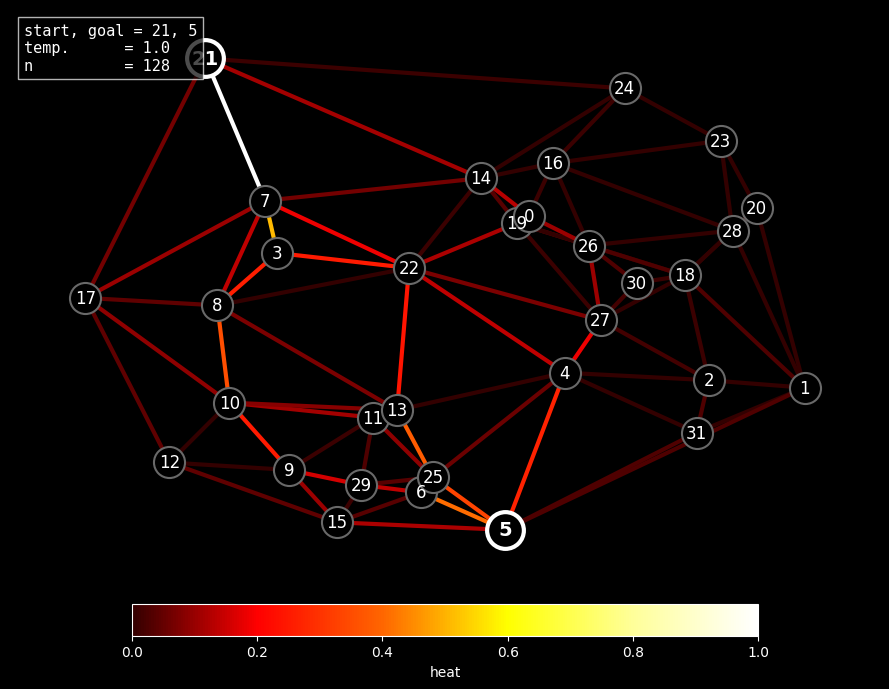

In [11]:
key_node_indices: set[int] = {start, goal}
notes = (
    f"start, goal = {start}, {goal}\n"
    f"temp.      = {temperature}\n"
    f"n          = {n_samples}"
)

G = nx.Graph()
for n in nodes:
    G.add_node(n.idx, pos=(n.x, n.y))

for e in heatmap:
    u, v = tuple(e.nodes)
    G.add_edge(u, v, heat=e.heat)

pos = nx.get_node_attributes(G, "pos")

heat_vals = np.asarray([G[u][v]["heat"] for u, v in G.edges()])
heat_vals = heat_vals / float(heat_vals.max())
norm = mpl.colors.Normalize(vmin=0.0, vmax=1.0)

cmap = mpl.colors.LinearSegmentedColormap.from_list(
    "thermal", ["#330000", "#FF0000", "#FF6600", "#FFFF00", "#FFFF99", "#FFFFFF"]
)
edge_colors = cmap(norm(heat_vals))
mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

plt.style.use("dark_background")
fig, ax = plt.subplots(figsize=(9, 7), facecolor="black")
ax.set_facecolor("black")

special   = [n for n in G.nodes if n in key_node_indices]
ordinary  = [n for n in G.nodes if n not in key_node_indices]

nx.draw_networkx_nodes(
    G,
    pos,
    ax=ax,
    nodelist=ordinary,
    node_size=500,
    node_color="black",
    edgecolors="dimgray",
    linewidths=1.5,
)

nx.draw_networkx_nodes(
    G,
    pos,
    ax=ax,
    nodelist=special,
    node_size=700,
    node_color="black",
    edgecolors="white",
    linewidths=3,
)

nx.draw_networkx_edges(G, pos, ax=ax, edge_color=edge_colors, width=3)

nx.draw_networkx_labels(
    G,
    pos,
    ax=ax,
    labels={n: n for n in ordinary},
    font_size=12,
    font_color="white",
    font_weight="normal",
)
nx.draw_networkx_labels(
    G,
    pos,
    ax=ax,
    labels={n: n for n in special},
    font_size=14,
    font_color="white",
    font_weight="bold",
)

ax.axis("off")

cbar = fig.colorbar(
    mappable,
    ax=ax,
    orientation="horizontal",
    fraction=0.05,
    pad=0.04,
)
cbar.set_label("heat")

atxt = AnchoredText(
    notes,
    loc="upper left",
    prop=dict(size=11, color="white", family="monospace"),
    frameon=True,
)
atxt.patch.set(edgecolor="white", facecolor="black", alpha=0.7)
ax.add_artist(atxt)

plt.tight_layout()

#plt.savefig("graph.png", dpi=300, bbox_inches="tight", facecolor="black")

plt.show()